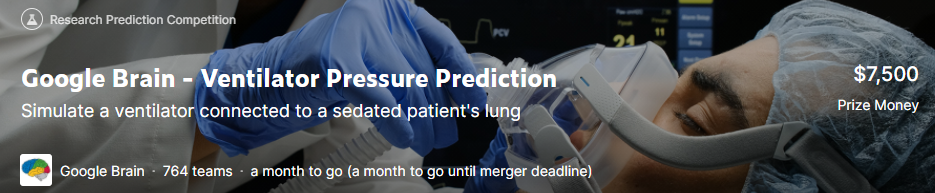

In this competition, you’ll simulate a ventilator connected to a sedated patient's lung. The best submissions will take lung attributes compliance and resistance into account.

In [ ]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
import warnings
warnings.simplefilter('ignore')

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Train data read</span>

In [ ]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
train

### HEATMAP

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Test data read</span>

In [ ]:
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
test

<pre>
id - globally-unique time step identifier across an entire file
breath_id - globally-unique time step for breaths
R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
time_step - the actual time stamp.
u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open). The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Train data Analyze</span>

In [ ]:
len(train.breath_id.unique())

In [ ]:
train.describe()

### breath_id 1
"pressure" seems to come a little later than "u_in".

In [ ]:
check = train[train['breath_id']==1]
#check['check'] = (np.log1p(check['u_in'] )+ np.log1p(check['u_out'])*2)*4
samples = ["u_in","pressure",'u_out']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

In [ ]:
check

### breath_id 2

In [ ]:
check = train[train['breath_id']==2]

check['check'] = (np.log1p(check['u_in'] )+ np.log1p(check['u_out'])*2)*4
samples = ["u_in","pressure",'u_out']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

### breath_id 3

In [ ]:
check = train[train['breath_id']==3]

samples = ["u_in","pressure",'u_out']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

### breath_id 1-9

In [ ]:
plt.figure(figsize=(20,5))
for i in range(1,10):
 check = train[train['breath_id']==i]

 samples = ["u_in","pressure",'u_out']

    
 plt.plot(check["time_step"],check['u_in'],color='r')
 plt.plot(check["time_step"],check['pressure'],color='b')
 plt.plot(check["time_step"],check['u_out'],color='y')
 plt.legend(fontsize=12)

### shift1 

In [ ]:
plt.figure(figsize=(20,5))
for i in range(1,10):
 check = train[train['breath_id']==i]

 samples = ["u_in","pressure",'u_out']
 a = check['u_in'].shift(1)
 b = check['pressure'].shift(1) 
    
 plt.plot(check["time_step"],check['u_in']-a,color='r')
 plt.plot(check["time_step"],check['pressure']-b,color='b')
 plt.legend(fontsize=12)

### shift2

In [ ]:
plt.figure(figsize=(20,5))
for i in range(1,10):
 check = train[train['breath_id']==i]

 samples = ["u_in","pressure",'u_out']
 a = check['u_in'].shift(2)
 b = check['pressure'].shift(2) 
    
 plt.plot(check["time_step"],check['u_in']-a,color='r')
 plt.plot(check["time_step"],check['pressure']-b,color='b')
 plt.legend(fontsize=12)

### shift3

In [ ]:
plt.figure(figsize=(20,5))
for i in range(1,10):
 check = train[train['breath_id']==i]

 samples = ["u_in","pressure",'u_out']
 a = check['u_in'].shift(3)
 b = check['pressure'].shift(3) 
    
 plt.plot(check["time_step"],check['u_in']-a,color='r')
 plt.plot(check["time_step"],check['pressure']-b,color='b')
 plt.legend(fontsize=12)

### shift4

In [ ]:
plt.figure(figsize=(20,5))
for i in range(1,10):
 check = train[train['breath_id']==i]

 samples = ["u_in","pressure",'u_out']
 a = check['u_in'].shift(4)
 b = check['pressure'].shift(4) 
    
 plt.plot(check["time_step"],check['u_in']-a,color='r')
 plt.plot(check["time_step"],check['pressure']-b,color='b')
 plt.legend(fontsize=12)

### u_in and u_in.shift(2)

In [ ]:
check = train[train['breath_id']==3]
check['u_in_lag'] = check['u_in'].shift(2).fillna(0)
samples = ["u_in","pressure",'u_in_lag']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)


### C and R

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=train)
plt.title('Counts of R in train');
plt.subplot(2, 2, 2)
sns.countplot(x='R', data=test)
plt.title('Counts of R in test');
plt.subplot(2, 2, 3)
sns.countplot(x='C', data=train)
plt.title('Counts of C in train');
plt.subplot(2, 2, 4)
sns.countplot(x='C', data=test)
plt.title('Counts of C in test');

thanks https://www.kaggle.com/artgor/ventilator-pressure-prediction-eda-fe-and-models

### What is R&C?
R and C seem to be adjusted for each patient.

In [ ]:
check = train[train['breath_id']==1]
samples = ["u_in","pressure",'R','C']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

In [ ]:
check = train[train['breath_id']==2]
samples = ["u_in","pressure",'R','C']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

In [ ]:
check.head()

In [ ]:
check = train[train['breath_id']==3]
samples = ["u_in","pressure",'R','C']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

## ewm=15

In [ ]:
check['ewm_u_in_mean'] = check.groupby('breath_id')['u_in'].ewm(halflife=15).mean().reset_index(level=0,drop=True)
check['ewm_u_in_std'] = check.groupby('breath_id')['u_in'].ewm(halflife=15).std().reset_index(level=0,drop=True) 
check['ewm_u_in_corr'] = check.groupby('breath_id')['u_in'].ewm(halflife=15).corr().reset_index(level=0,drop=True) 
samples = ["ewm_u_in_mean","ewm_u_in_std","ewm_u_in_corr","pressure"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

## ewm=8

In [ ]:
check['ewm_u_in_mean'] = check.groupby('breath_id')['u_in'].ewm(halflife=8).mean().reset_index(level=0,drop=True)
check['ewm_u_in_std'] = check.groupby('breath_id')['u_in'].ewm(halflife=8).std().reset_index(level=0,drop=True) 
check['ewm_u_in_corr'] = check.groupby('breath_id')['u_in'].ewm(halflife=8).corr().reset_index(level=0,drop=True) 
samples = ["ewm_u_in_mean","ewm_u_in_std","ewm_u_in_corr","pressure"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

## Rolling=15

In [ ]:
check[["15_in_max","15_out_std"]] = check.groupby('breath_id')['u_in'].rolling(window=15,min_periods=1).agg({"15_in_max":"max","15_in_std":"std"}).reset_index(level=0,drop=True)
samples = ["15_in_max","15_out_std","pressure"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

## Rolling=8

In [ ]:
check[["8_in_max","8_out_std"]] = check.groupby('breath_id')['u_in'].rolling(window=8,min_periods=1).agg({"8_in_max":"max","8_in_std":"std"}).reset_index(level=0,drop=True)
samples = ["8_in_max","8_out_std","pressure"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

## Rolling=4

In [ ]:
check[["4_in_max","4_out_std"]] = check.groupby('breath_id')['u_in'].rolling(window=4,min_periods=1).agg({"4_in_max":"max","4_in_std":"std"}).reset_index(level=0,drop=True)
samples = ["4_in_max","4_out_std","pressure"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
plt.legend(fontsize=12)

## u_in_cumsum

In [ ]:
check['u_in_cumsum'] = (check['u_in']).groupby(check['breath_id']).cumsum()
samples = ['u_in',"u_in_cumsum","pressure"]

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
#plt.plot(check["seconds_in_bucket"],check_trade["size"],label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Test data Analyze</span>

In [ ]:
len(test.breath_id.unique())

In [ ]:
test.describe()

In [ ]:
check = test[test['breath_id']==0]

samples = ["u_in",'u_out']

plt.figure(figsize=(20,5))

for num,idx in enumerate(samples):
    
    plt.plot(check["time_step"],check[idx],label=idx)
#plt.plot(check["seconds_in_bucket"],check_trade["size"],label="trade_parquet")
plt.legend(fontsize=12)

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Submit data read</span>

In [ ]:
sub = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
sub

😺😅㊙🔰🗑⬛🟥🟨🟩